# Part 3- Feature and ML Pipelines

Created by Michael Casey, Andrew Cruez, Peter Stewart, and Hemraj Yadav

__About Part 3__
In this part we will look at the Scikit-learn module and after pre-processing the dataset, we will run multiple experiments, changing the hyperparameters to determeine our best model for creating our submission file to test our data in the Kaggle competiion.

In [1]:
# Importing our modules and settings and loading our data from part 1 and 2

import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, ComplementNB
from time import time
import featuretools as ft
import warnings
import pickle
import woodwork as ww
from scipy.stats import t

warnings.filterwarnings('ignore')

# Load data from part I
DATA_DIR = "./Data/home-credit-default-risk"

with open(f"{DATA_DIR}/datasets.pkl", 'rb') as n:
    datasets = pickle.load(n)

with open(f"{DATA_DIR}/X_train_FT.pkl", 'rb') as r:
    X_train_FT = pickle.load(r)

with open(f"{DATA_DIR}/X_test_FT.pkl", 'rb') as e:
    X_test_FT = pickle.load(e)

with open(f"{DATA_DIR}/X_train_MF.pkl", 'rb') as mr:
    X_train_MF = pickle.load(mr)

with open(f"{DATA_DIR}/X_test_MF.pkl", 'rb') as me:
    X_test_MF = pickle.load(me)

In [2]:
#Get rid of duplicate columns (basically the original data cols)
kp_list = (X_train_FT.columns.difference(X_train_MF.columns))
print(len(kp_list))
kp_list

1080


Index(['COUNT(bureau_balance_FT)', 'COUNT(cash_FT)', 'COUNT(credit_FT)',
       'COUNT(installments_FT)', 'COUNT(previous_FT)',
       'MAX(bureau_FT.AMT_ANNUITY)', 'MAX(bureau_FT.AMT_CREDIT_MAX_OVERDUE)',
       'MAX(bureau_FT.AMT_CREDIT_SUM)', 'MAX(bureau_FT.AMT_CREDIT_SUM_DEBT)',
       'MAX(bureau_FT.AMT_CREDIT_SUM_LIMIT)',
       ...
       'SUM(previous_FT.DAYS_LAST_DUE)',
       'SUM(previous_FT.DAYS_LAST_DUE_1ST_VERSION)',
       'SUM(previous_FT.DAYS_TERMINATION)',
       'SUM(previous_FT.HOUR_APPR_PROCESS_START)',
       'SUM(previous_FT.NFLAG_INSURED_ON_APPROVAL)',
       'SUM(previous_FT.NFLAG_LAST_APPL_IN_DAY)',
       'SUM(previous_FT.RATE_DOWN_PAYMENT)',
       'SUM(previous_FT.RATE_INTEREST_PRIMARY)',
       'SUM(previous_FT.RATE_INTEREST_PRIVILEGED)',
       'SUM(previous_FT.SELLERPLACE_AREA)'],
      dtype='object', length=1080)

In [3]:
# We should get a matching number and empty list below proving that test and train FT sets have same cols.
kp_list_tst = (X_test_FT.columns.difference(X_test_MF.columns))
print(len(kp_list))
print(kp_list_tst.difference(kp_list))

1080
Index([], dtype='object')


In [4]:
# combine train datasets for ML train set
X_train = X_train_MF.merge(X_train_FT[kp_list], left_index=True, right_index=True, how='outer')
print(X_train.shape)

(307511, 1299)


In [5]:
# This will be our "Set-Aside" copy since this test set doesn't contain tagets we can't use to train the model, only to submit for Kaggle score.
X_test_SA = X_test_MF.merge(X_test_FT[kp_list], left_index=True, right_index=True, how='outer')
print(X_test_SA.shape)

(48744, 1298)


In [6]:
X_train.drop('SK_ID_CURR', axis=1, inplace=True)
print(X_train.shape)
X_test_SA.drop('SK_ID_CURR', axis=1, inplace=True)
print(X_test_SA.shape)

(307511, 1298)
(48744, 1297)


In [7]:
# Here we define the preprocessing pipelines for our data
BL_num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ])

BL_cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

MNB_num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant',fill_value= 0)),
        ('scaler', MinMaxScaler()),
    ])

new_num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant',fill_value= 0)),
        ('scaler', MinMaxScaler()),
    ])

In [8]:
# split out the target column to creat y values
y_train = X_train['TARGET']
X_train = X_train.loc[:, ~X_train.columns.isin(['TARGET'])]
print(X_train.shape)
X_train.head()

(307511, 1297)


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,SUM(previous_FT.DAYS_LAST_DUE),SUM(previous_FT.DAYS_LAST_DUE_1ST_VERSION),SUM(previous_FT.DAYS_TERMINATION),SUM(previous_FT.HOUR_APPR_PROCESS_START),SUM(previous_FT.NFLAG_INSURED_ON_APPROVAL),SUM(previous_FT.NFLAG_LAST_APPL_IN_DAY),SUM(previous_FT.RATE_DOWN_PAYMENT),SUM(previous_FT.RATE_INTEREST_PRIMARY),SUM(previous_FT.RATE_INTEREST_PRIVILEGED),SUM(previous_FT.SELLERPLACE_AREA)
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,-25.0,125.0,-17.00,9.0,0.0,1.0,0.000000,0.0,0.0,500.0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,-3163.0,-3013.0,-3142.00,44.0,2.0,3.0,0.150091,0.0,0.0,1599.0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,-724.0,-694.0,-714.00,5.0,0.0,1.0,0.212008,0.0,0.0,30.0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,1642297.5,824256.0,1642335.75,132.0,0.0,9.0,1.470709,0.0,0.0,8048.0
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,432817.2,-5023.2,432862.80,74.0,3.6,6.0,0.957098,0.0,0.0,2455.0


In [9]:
# create train test and valid sets from X and Y train data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [4]:
#Now let's determine which features are categorical or numerical for our X_train_FT dataset
numerical_at = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_at = X_train.select_dtypes(include=['object', 'bool']).columns


In [5]:
# check to make sure our cat/num lists have all the columns from original dataset
# make sure all categorical data is string type
X_train[categorical_at]=X_train[categorical_at].astype(str)
tot_from_above = (len(numerical_at)+len(categorical_at))
print (X_train.shape[1])
print (tot_from_above)
X_train.info()

1297
1297
<class 'pandas.core.frame.DataFrame'>
Int64Index: 209107 entries, 35339 to 212146
Columns: 1297 entries, NAME_CONTRACT_TYPE to SUM(previous_FT.SELLERPLACE_AREA)
dtypes: float64(1233), int64(44), object(20)
memory usage: 2.0+ GB


In [8]:
#Run our X_train through the column transformer to store the input number and check the output
data_pipeline = ColumnTransformer(transformers=[
       ("num_pipeline", new_num_pipeline, numerical_at),
       ("cat_pipeline", BL_cat_pipeline, categorical_at)],
       remainder='drop',
        n_jobs=1
   )

X_train_transformed = data_pipeline.fit_transform(X_train)

column_names = list(numerical_at) + list(data_pipeline.transformers_[1][1].named_steps["ohe"].get_feature_names(categorical_at))
# print(column_names)
display(pd.DataFrame(X_train_transformed,  columns=column_names).head())
number_of_inputs = X_train_transformed.shape[1]

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan,ApprovedorRejected_x_0,ApprovedorRejected_x_Approved,ApprovedorRejected_y_0,ApprovedorRejected_y_Refused,ACTIVE_CLOSED_SUM_BUREAU_x_0,ACTIVE_CLOSED_SUM_BUREAU_x_ACTIVE,ACTIVE_CLOSED_SUM_BUREAU_y_0,ACTIVE_CLOSED_SUM_BUREAU_y_CLOSED
0,0.105263,0.008783,0.123596,0.113535,0.133333,0.282797,0.797238,0.038258,0.791168,0.684313,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.052632,0.014795,0.428742,0.180139,0.388889,0.336758,0.689684,0.037863,0.928852,0.440461,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.000000,0.008115,0.029146,0.044124,0.033333,0.136490,0.064713,1.000000,0.487573,0.395026,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.000000,0.003106,0.056180,0.053995,0.066667,0.421848,0.365953,0.033240,0.663862,0.684452,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.000000,0.013125,0.333611,0.147701,0.297778,0.421848,0.913078,0.042066,0.835625,0.791719,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


# Model and Experiment Pipeline

The next section of the notebook is the model and experiment pipeline which is where we will run our data through a series of experiments with multilayer perceptron, binomial logistic regression, and multinomial naïve bayes algorithms. We will select our best model from these options to submit for scoring on Kaggle.

**Perceptron Loss Function:**
$${\displaystyle {\frac {1} {m}} \sum _{i=1}^{M} {Max}(0,−X^T_i*W*y_i) }$$

## Multilayer Perceptron

In [17]:
# First doing a gridsearch for best params for MLPClassifer


pipeline = Pipeline([
        ('dpipe', data_pipeline),
        ('feat_sel', SelectKBest(chi2, k=50)),
        ('MLPC', MLPClassifier(random_state=42))
])

parameters = { 
    'MLPC__activation': ('logistic', 'relu'),
    'MLPC__solver': ('lbfgs', 'sgd', 'adam'),
}
grid_search = GridSearchCV(pipeline, parameters, scoring='roc_auc' ,cv=3, n_jobs=1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
preds = grid_search.predict_proba(X_train)
accuracy = roc_auc_score(y_train, preds[:,1])

results = pd.DataFrame(columns=["Model", "Test Accuracy"])
results.loc[len(results)] = ["MLPClassifier", np.round(accuracy, 3)]
results

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.725
Best parameters set:
	MLPC__activation: 'relu'
	MLPC__solver: 'lbfgs'


,Model,Test Accuracy
0,MLPClassifier,0.758


It looks like our gridsearch found the best parameters to be activation = relu and solver = lbfgs. Now we'll use those values to run some experiments. We are going to play with the values of K first, this will determine how many features we will use in the model with the chi squared method as the selector. Our first experiment is k = 200.

In [18]:

pipeline = Pipeline([
        ('dpipe', data_pipeline),
        ('feat_sel', SelectKBest(chi2, k=200)),
        ('MLP', MLPClassifier(activation= 'relu', solver = 'lbfgs', random_state=42)),

])

t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)
trainAcc  = pipeline.score(X_train, y_train)
validAcc  = pipeline.score(X_valid, y_valid)
testAcc  = pipeline.score(X_test, y_test)
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])




try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime", "TrainAcc", "TestAcc","ValidationAcc", 
                                               "Train_Auc", "Test_Auc", "Valid_Auc", "Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline MLPClassifier with {number_of_inputs} inputs", run_time ,
                                        f"{trainAcc*100:8.2f}%",f"{testAcc*100:8.2f}%",f"{validAcc*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "MLPClassifier pipeline with K = 200",]

experimentLog


,Pipeline,RunTime,TrainAcc,TestAcc,ValidationAcc,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,107.85056,92.09%,91.81%,91.58%,78.08%,72.89%,73.00%,MLPClassifier pipeline with K = 200


In [19]:
# Now let's try an experiment with k values 100 on the selector


pipeline = Pipeline([
        ('dpipe', data_pipeline),
        ('feat_sel', SelectKBest(chi2, k=100)),
        ('MLP', MLPClassifier(activation= 'logistic', solver = 'sgd', random_state=42)),

])

t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)
trainAcc  = pipeline.score(X_train, y_train)
validAcc  = pipeline.score(X_valid, y_valid)
testAcc  = pipeline.score(X_test, y_test)
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])




try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime", "TrainAcc", "TestAcc","ValidationAcc", 
                                               "Train_Auc", "Test_Auc", "Valid_Auc", "Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline MLPClassifier with {number_of_inputs} inputs", run_time ,
                                        f"{trainAcc*100:8.2f}%",f"{testAcc*100:8.2f}%",f"{validAcc*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "MLPClassifier pipeline with K = 100",]

experimentLog

,Pipeline,RunTime,TrainAcc,TestAcc,ValidationAcc,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,107.85056,92.09%,91.81%,91.58%,78.08%,72.89%,73.00%,MLPClassifier pipeline with K = 200
1,Baseline MLPClassifier with 1431 inputs,55.13610,91.99%,91.94%,91.64%,72.09%,72.59%,72.77%,MLPClassifier pipeline with K = 100


In [20]:
# We can see a little difference between 100 and 200 so let's try 300

pipeline = Pipeline([
        ('dpipe', data_pipeline),
        ('feat_sel', SelectKBest(chi2, k=300)),
        ('MLP', MLPClassifier(activation= 'relu', solver = 'lbfgs', random_state=42)),

])

t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)
trainAcc  = pipeline.score(X_train, y_train)
validAcc  = pipeline.score(X_valid, y_valid)
testAcc  = pipeline.score(X_test, y_test)
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])




try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime", "TrainAcc", "TestAcc","ValidationAcc", 
                                               "Train_Auc", "Test_Auc", "ValidAuc", "Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline MLPClassifier with {number_of_inputs} inputs", run_time ,
                                        f"{trainAcc*100:8.2f}%",f"{testAcc*100:8.2f}%",f"{validAcc*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "MLPClassifier pipeline with  K = 300",]

experimentLog

,Pipeline,RunTime,TrainAcc,TestAcc,ValidationAcc,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,107.850560,92.09%,91.81%,91.58%,78.08%,72.89%,73.00%,MLPClassifier pipeline with K = 200
1,Baseline MLPClassifier with 1431 inputs,55.136100,91.99%,91.94%,91.64%,72.09%,72.59%,72.77%,MLPClassifier pipeline with K = 100
2,Baseline MLPClassifier with 1431 inputs,114.054762,92.16%,91.61%,91.35%,79.37%,73.33%,73.60%,MLPClassifier pipeline with K = 300


With our first 3 experiments we find that as we increase the value of K we have longer processing times and increases in accuracy of less than 1% per 100 K increase. Next we will do some experimentation with PCA which will reduce the dimensions of our data based on the value that we enter for the component count.

In [21]:
# Next let's run an experiment with PCA set to create 50 compnents.

pipeline = Pipeline([
        ('dpipe', data_pipeline),
        ('pca', PCA(n_components=50)),
        ('MLP', MLPClassifier(activation= 'relu', solver = 'lbfgs', random_state=42)),

])

t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)
trainAcc  = pipeline.score(X_train, y_train)
validAcc  = pipeline.score(X_valid, y_valid)
testAcc  = pipeline.score(X_test, y_test)
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])



try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime", "TrainAcc", "TestAcc","ValidationAcc", 
                                               "Train_Auc", "Test_Auc", "valid_Auc", "Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline MLPClassifier with {number_of_inputs} inputs", run_time ,
                                        f"{trainAcc*100:8.2f}%",f"{testAcc*100:8.2f}%",f"{validAcc*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "MLPClassifier pipeline with PCA 50 comp",]

experimentLog

,Pipeline,RunTime,TrainAcc,TestAcc,ValidationAcc,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,107.850560,92.09%,91.81%,91.58%,78.08%,72.89%,73.00%,MLPClassifier pipeline with K = 200
1,Baseline MLPClassifier with 1431 inputs,55.136100,91.99%,91.94%,91.64%,72.09%,72.59%,72.77%,MLPClassifier pipeline with K = 100
2,Baseline MLPClassifier with 1431 inputs,114.054762,92.16%,91.61%,91.35%,79.37%,73.33%,73.60%,MLPClassifier pipeline with K = 300
3,Baseline MLPClassifier with 1431 inputs,89.093591,92.12%,86.99%,86.44%,78.87%,65.77%,65.59%,MLPClassifier pipeline with PCA 50 comp


In [22]:
# Next let's run an experiment with PCA creating 150 dimensions based on our data


pipeline = Pipeline([
        ('dpipe', data_pipeline),
        ('pca', PCA(n_components=150)),
        ('MLP', MLPClassifier(activation= 'relu', solver = 'lbfgs', random_state=42)),

])

t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)
trainAcc  = pipeline.score(X_train, y_train)
validAcc  = pipeline.score(X_valid, y_valid)
testAcc  = pipeline.score(X_test, y_test)
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])



try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime", "TrainAcc", "TestAcc","ValidationAcc", 
                                               "Train_Auc", "Test_Auc", "Valid_Auc", "Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline MLPClassifier with {number_of_inputs} inputs", run_time ,
                                        f"{trainAcc*100:8.2f}%",f"{testAcc*100:8.2f}%",f"{validAcc*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "MLPClassifier pipeline with PCA 150 comp",]

experimentLog

,Pipeline,RunTime,TrainAcc,TestAcc,ValidationAcc,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,107.850560,92.09%,91.81%,91.58%,78.08%,72.89%,73.00%,MLPClassifier pipeline with K = 200
1,Baseline MLPClassifier with 1431 inputs,55.136100,91.99%,91.94%,91.64%,72.09%,72.59%,72.77%,MLPClassifier pipeline with K = 100
2,Baseline MLPClassifier with 1431 inputs,114.054762,92.16%,91.61%,91.35%,79.37%,73.33%,73.60%,MLPClassifier pipeline with K = 300
3,Baseline MLPClassifier with 1431 inputs,89.093591,92.12%,86.99%,86.44%,78.87%,65.77%,65.59%,MLPClassifier pipeline with PCA 50 comp
4,Baseline MLPClassifier with 1431 inputs,114.665470,92.76%,89.84%,89.61%,86.30%,68.73%,69.08%,MLPClassifier pipeline with PCA 150 comp


In [23]:
# Next let's run an experiment with PCA creating 250 dimensions based on our data

pipeline = Pipeline([
        ('dpipe', data_pipeline),
        ('pca', PCA(n_components=250)),
        ('MLP', MLPClassifier(activation= 'relu', solver = 'lbfgs', random_state=42)),

])

t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)
trainAcc  = pipeline.score(X_train, y_train)
validAcc  = pipeline.score(X_valid, y_valid)
testAcc  = pipeline.score(X_test, y_test)
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])



try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime", "TrainAcc", "TestAcc","ValidationAcc", 
                                               "Train_Auc", "Test_Auc", "Valid_Auc", "Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline MLPClassifier with {number_of_inputs} inputs", run_time ,
                                        f"{trainAcc*100:8.2f}%",f"{testAcc*100:8.2f}%",f"{validAcc*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "MLPClassifier pipeline with PCA of 250 comp",]

experimentLog

,Pipeline,RunTime,TrainAcc,TestAcc,ValidationAcc,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,107.850560,92.09%,91.81%,91.58%,78.08%,72.89%,73.00%,MLPClassifier pipeline with K = 200
1,Baseline MLPClassifier with 1431 inputs,55.136100,91.99%,91.94%,91.64%,72.09%,72.59%,72.77%,MLPClassifier pipeline with K = 100
2,Baseline MLPClassifier with 1431 inputs,114.054762,92.16%,91.61%,91.35%,79.37%,73.33%,73.60%,MLPClassifier pipeline with K = 300
3,Baseline MLPClassifier with 1431 inputs,89.093591,92.12%,86.99%,86.44%,78.87%,65.77%,65.59%,MLPClassifier pipeline with PCA 50 comp
4,Baseline MLPClassifier with 1431 inputs,114.665470,92.76%,89.84%,89.61%,86.30%,68.73%,69.08%,MLPClassifier pipeline with PCA 150 comp
5,Baseline MLPClassifier with 1431 inputs,118.564886,93.09%,89.20%,89.01%,88.04%,68.68%,69.90%,MLPClassifier pipeline with PCA of 250 comp


After running several PCA values for our model we see that the best overall AUC score is achieved with 250 components but this was only a small increase over 150 components which in turn was a larger increase over 50 components. For our final experiment with MLP let’s try running without trimming the features or dimension reduction and see how the score does with the full dataset.

In [24]:
# Next let's run an experiment with PCA creating 250 dimensions based on our data


pipeline = Pipeline([
        ('dpipe', data_pipeline),
        ('MLP', MLPClassifier(activation= 'logistic', solver = 'sgd', random_state=42)),

])

t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)
trainAcc  = pipeline.score(X_train, y_train)
validAcc  = pipeline.score(X_valid, y_valid)
testAcc  = pipeline.score(X_test, y_test)
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])



try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime", "TrainAcc", "TestAcc","ValidationAcc", 
                                               "Train_Auc", "Test_Auc", "Valid_Auc", "Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline MLPClassifier with {number_of_inputs} inputs", run_time ,
                                        f"{trainAcc*100:8.2f}%",f"{testAcc*100:8.2f}%",f"{validAcc*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "MLPClass pipeline full data, log, sgd",]

experimentLog

,Pipeline,RunTime,TrainAcc,TestAcc,ValidationAcc,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,107.850560,92.09%,91.81%,91.58%,78.08%,72.89%,73.00%,MLPClassifier pipeline with K = 200
1,Baseline MLPClassifier with 1431 inputs,55.136100,91.99%,91.94%,91.64%,72.09%,72.59%,72.77%,MLPClassifier pipeline with K = 100
2,Baseline MLPClassifier with 1431 inputs,114.054762,92.16%,91.61%,91.35%,79.37%,73.33%,73.60%,MLPClassifier pipeline with K = 300
3,Baseline MLPClassifier with 1431 inputs,89.093591,92.12%,86.99%,86.44%,78.87%,65.77%,65.59%,MLPClassifier pipeline with PCA 50 comp
4,Baseline MLPClassifier with 1431 inputs,114.665470,92.76%,89.84%,89.61%,86.30%,68.73%,69.08%,MLPClassifier pipeline with PCA 150 comp
5,Baseline MLPClassifier with 1431 inputs,118.564886,93.09%,89.20%,89.01%,88.04%,68.68%,69.90%,MLPClassifier pipeline with PCA of 250 comp
6,Baseline MLPClassifier with 1431 inputs,294.561357,92.00%,91.91%,91.67%,74.56%,74.84%,74.84%,"MLPClass pipeline full data, log, relu"


In [25]:

pipeline = Pipeline([
        ('dpipe', data_pipeline),
        ('MLP', MLPClassifier(activation= 'relu', solver = 'lbfgs', random_state=42)),

])

t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)
trainAcc  = pipeline.score(X_train, y_train)
validAcc  = pipeline.score(X_valid, y_valid)
testAcc  = pipeline.score(X_test, y_test)
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])



try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime", "TrainAcc", "TestAcc","ValidationAcc", 
                                               "Train_Auc", "Test_Auc", "Valid_Auc", "Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline MLPClassifier with {number_of_inputs} inputs", run_time ,
                                        f"{trainAcc*100:8.2f}%",f"{testAcc*100:8.2f}%",f"{validAcc*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "MLPClass pipeline full data, relu, lbfgs",]

experimentLog

,Pipeline,RunTime,TrainAcc,TestAcc,ValidationAcc,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,107.850560,92.09%,91.81%,91.58%,78.08%,72.89%,73.00%,MLPClassifier pipeline with K = 200
1,Baseline MLPClassifier with 1431 inputs,55.136100,91.99%,91.94%,91.64%,72.09%,72.59%,72.77%,MLPClassifier pipeline with K = 100
2,Baseline MLPClassifier with 1431 inputs,114.054762,92.16%,91.61%,91.35%,79.37%,73.33%,73.60%,MLPClassifier pipeline with K = 300
3,Baseline MLPClassifier with 1431 inputs,89.093591,92.12%,86.99%,86.44%,78.87%,65.77%,65.59%,MLPClassifier pipeline with PCA 50 comp
4,Baseline MLPClassifier with 1431 inputs,114.665470,92.76%,89.84%,89.61%,86.30%,68.73%,69.08%,MLPClassifier pipeline with PCA 150 comp
5,Baseline MLPClassifier with 1431 inputs,118.564886,93.09%,89.20%,89.01%,88.04%,68.68%,69.90%,MLPClassifier pipeline with PCA of 250 comp
6,Baseline MLPClassifier with 1431 inputs,294.561357,92.00%,91.91%,91.67%,74.56%,74.84%,74.84%,"MLPClass pipeline full data, log, relu"
7,Baseline MLPClassifier with 1431 inputs,273.255891,92.06%,91.94%,91.65%,77.34%,75.76%,75.92%,"MLPClass pipeline full data, relu, lbfgs"


In [29]:
#Backing up the data to make it easier to restart the kernel if neccesary

with open(f'{DATA_DIR}/X_train.pkl', 'wb') as a:
    pickle.dump(X_train, a)

with open(f'{DATA_DIR}/X_test.pkl', 'wb') as b:
    pickle.dump(X_test, b)

with open(f'{DATA_DIR}/y_train.pkl', 'wb') as c:
    pickle.dump(y_train, c)

with open(f'{DATA_DIR}/y_test.pkl', 'wb') as d:
    pickle.dump(y_test, d)

with open(f'{DATA_DIR}/X_valid.pkl', 'wb') as e:
    pickle.dump(X_valid, e)

with open(f'{DATA_DIR}/y_valid.pkl', 'wb') as f:
    pickle.dump(y_valid, f)

with open(f'{DATA_DIR}/X_test_SA.pkl', 'wb') as g:
    pickle.dump(X_test_SA, g)

with open(f'{DATA_DIR}/exp_log.pkl', 'wb') as h:
    pickle.dump(experimentLog, h)



In [2]:
with open(f"{DATA_DIR}/X_train.pkl", 'rb') as aa:
    X_train = pickle.load(aa)

with open(f"{DATA_DIR}/X_test.pkl", 'rb') as bb:
    X_test = pickle.load(bb)

with open(f"{DATA_DIR}/y_train.pkl", 'rb') as cc:
    y_train = pickle.load(cc)

with open(f"{DATA_DIR}/y_test.pkl", 'rb') as dd:
    y_test = pickle.load(dd)

with open(f"{DATA_DIR}/X_valid.pkl", 'rb') as ee:
    X_valid = pickle.load(ee)

with open(f"{DATA_DIR}/y_valid.pkl", 'rb') as ff:
    y_valid = pickle.load(ff)

with open(f"{DATA_DIR}/X_test_SA.pkl", 'rb') as gg:
    X_test_SA = pickle.load(gg)

with open(f"{DATA_DIR}/exp_log.pkl", 'rb') as hh:
    experimentLog = pickle.load(hh)

## Binomial Logistic Regression with Regularization
The objective function for the learning a  binomial logistic regression model (log loss) can be stated as follows:


<!-- $$
\underset{\mathbf{\theta}}{\operatorname{argmin}}\left[\operatorname{CXE}\right] = \underset{\mathbf{\theta}}{\operatorname{argmin}} \left[ -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) \right]} \right] $$ -->

$$  -\frac{1}{m}\sum^m_{i=1}\left(y_i\cdot\:\log\:\left(p_i\right)\:+\:\left(1-y_i\right)\cdot\log\left(1-p_i\right)\right) $$

In [26]:
# Part1 build the pipline in gridsearchcv to find the best params

pipeline = Pipeline([
        ('dpipe', data_pipeline),
        ('pca', PCA(n_components=150)),
        ('logistic', LogisticRegression(random_state=42))
])

parameters = { 
    'logistic__penalty': ('l1', 'l2', 'elasticnet', 'none'),
    'logistic__C':[10, 100.0, 1000.0, 10000.0],
}



grid_search = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=3, n_jobs=1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
preds = grid_search.predict_proba(X_train)
accuracy = roc_auc_score(y_train, preds[:,1])

results = pd.DataFrame(columns=["Model", "Test Accuracy"])
results.loc[len(results)] = ["logistic", np.round(accuracy, 3)]
results

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best score: 0.920
Best parameters set:
	logistic__C: 10
	logistic__penalty: 'l2'


,Model,Test Accuracy
0,logistic,0.748


In [10]:
# Part1 build the pipline in gridsearchcv to find the best params

pipeline = Pipeline([
        ('dpipe', data_pipeline),
        ('pca', PCA(n_components=150)),
        ('logistic', LogisticRegression(penalty='l2', random_state=42))
])

parameters = { 
    'logistic__C':[10, 100.0, 1000.0, 10000.0],
    'logistic__solver':('lbfgs', 'liblinear', 'newton-cg')
}



grid_search = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=3, n_jobs=1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
preds = grid_search.predict_proba(X_train)
accuracy = roc_auc_score(y_train, preds[:,1])

results = pd.DataFrame(columns=["Model", "Test Accuracy"])
results.loc[len(results)] = ["logistic", np.round(accuracy, 3)]
results

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best score: 0.745
Best parameters set:
	logistic__C: 10000.0
	logistic__solver: 'newton-cg'


,Model,Test Accuracy
0,logistic,0.747


In [11]:
# for this experiment let's go with 10000 for C, and PCA 150



pipeline = Pipeline([
        ('dpipe', data_pipeline),
        ('pca', PCA(n_components=150)),
        ('logistic', LogisticRegression(penalty='l2', C  = 10000.0, solver='newton-cg'))
])
# Time and score test predictions
t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)
trainAcc  = pipeline.score(X_train, y_train)
validAcc  = pipeline.score(X_valid, y_valid)
testAcc  = pipeline.score(X_test, y_test)
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test) [:, 1])
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train) [:, 1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])



# del experimentLog
try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime", "TrainAcc", "TestAcc","ValidationAcc", 
                                               "Train_Auc", "Test_Auc", "Valid_Auc","Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline LogReg with {number_of_inputs} inputs", run_time,
                                        f"{trainAcc*100:8.2f}%",f"{testAcc*100:8.2f}%",f"{validAcc*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "logistic regression with c:10000 and PCA 150",]

experimentLog


,Pipeline,RunTime,TrainAcc,TestAcc,ValidationAcc,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,107.850560,92.09%,91.81%,91.58%,78.08%,72.89%,73.00%,MLPClassifier pipeline with K = 200
1,Baseline MLPClassifier with 1431 inputs,55.136100,91.99%,91.94%,91.64%,72.09%,72.59%,72.77%,MLPClassifier pipeline with K = 100
2,Baseline MLPClassifier with 1431 inputs,114.054762,92.16%,91.61%,91.35%,79.37%,73.33%,73.60%,MLPClassifier pipeline with K = 300
3,Baseline MLPClassifier with 1431 inputs,89.093591,92.12%,86.99%,86.44%,78.87%,65.77%,65.59%,MLPClassifier pipeline with PCA 50 comp
4,Baseline MLPClassifier with 1431 inputs,114.665470,92.76%,89.84%,89.61%,86.30%,68.73%,69.08%,MLPClassifier pipeline with PCA 150 comp
5,Baseline MLPClassifier with 1431 inputs,118.564886,93.09%,89.20%,89.01%,88.04%,68.68%,69.90%,MLPClassifier pipeline with PCA of 250 comp
6,Baseline MLPClassifier with 1431 inputs,294.561357,92.00%,91.91%,91.67%,74.56%,74.84%,74.84%,"MLPClass pipeline full data, log, relu"
7,Baseline MLPClassifier with 1431 inputs,273.255891,92.06%,91.94%,91.65%,77.34%,75.76%,75.92%,"MLPClass pipeline full data, relu, lbfgs"
8,Baseline LogReg with 1431 inputs,29.191555,92.00%,91.92%,91.68%,74.79%,74.86%,74.79%,logistic regression with c:10000 and PCA 150


In [12]:

pipeline = Pipeline([
        ('dpipe', data_pipeline),
        ('pca', PCA(n_components=150)),
        ('logistic', LogisticRegression(penalty='l2', C  = 10.0, solver='newton-cg'))
])
# Time and score test predictions
t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)
trainAcc  = pipeline.score(X_train, y_train)
validAcc  = pipeline.score(X_valid, y_valid)
testAcc  = pipeline.score(X_test, y_test)
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test) [:, 1])
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train) [:, 1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])



# del experimentLog
try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime", "TrainAcc", "TestAcc","ValidationAcc", 
                                               "Train_Auc", "Test_Auc", "Valid_Auc","Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline LogReg with {number_of_inputs} inputs", run_time,
                                        f"{trainAcc*100:8.2f}%",f"{testAcc*100:8.2f}%",f"{validAcc*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "logistic regression with c:10 and PCA 150",]

experimentLog

,Pipeline,RunTime,TrainAcc,TestAcc,ValidationAcc,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,107.850560,92.09%,91.81%,91.58%,78.08%,72.89%,73.00%,MLPClassifier pipeline with K = 200
1,Baseline MLPClassifier with 1431 inputs,55.136100,91.99%,91.94%,91.64%,72.09%,72.59%,72.77%,MLPClassifier pipeline with K = 100
2,Baseline MLPClassifier with 1431 inputs,114.054762,92.16%,91.61%,91.35%,79.37%,73.33%,73.60%,MLPClassifier pipeline with K = 300
3,Baseline MLPClassifier with 1431 inputs,89.093591,92.12%,86.99%,86.44%,78.87%,65.77%,65.59%,MLPClassifier pipeline with PCA 50 comp
4,Baseline MLPClassifier with 1431 inputs,114.665470,92.76%,89.84%,89.61%,86.30%,68.73%,69.08%,MLPClassifier pipeline with PCA 150 comp
5,Baseline MLPClassifier with 1431 inputs,118.564886,93.09%,89.20%,89.01%,88.04%,68.68%,69.90%,MLPClassifier pipeline with PCA of 250 comp
6,Baseline MLPClassifier with 1431 inputs,294.561357,92.00%,91.91%,91.67%,74.56%,74.84%,74.84%,"MLPClass pipeline full data, log, relu"
7,Baseline MLPClassifier with 1431 inputs,273.255891,92.06%,91.94%,91.65%,77.34%,75.76%,75.92%,"MLPClass pipeline full data, relu, lbfgs"
8,Baseline LogReg with 1431 inputs,29.191555,92.00%,91.92%,91.68%,74.79%,74.86%,74.79%,logistic regression with c:10000 and PCA 150
9,Baseline LogReg with 1431 inputs,28.218472,92.00%,91.91%,91.67%,74.74%,74.75%,74.78%,logistic regression with c:10 and PCA 150


In [13]:
pipeline = Pipeline([
        ('dpipe', data_pipeline),
        ('logistic', LogisticRegression(penalty='l2', C  = 10000.0, solver='newton-cg'))
])
# Time and score test predictions
t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)
trainAcc  = pipeline.score(X_train, y_train)
validAcc  = pipeline.score(X_valid, y_valid)
testAcc  = pipeline.score(X_test, y_test)
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test) [:, 1])
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train) [:, 1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])



# del experimentLog
try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime", "TrainAcc", "TestAcc","ValidationAcc", 
                                               "Train_Auc", "Test_Auc", "Valid_Auc","Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline LogReg with {number_of_inputs} inputs", run_time,
                                        f"{trainAcc*100:8.2f}%",f"{testAcc*100:8.2f}%",f"{validAcc*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "logistic regression with c:10000 and full set",]

experimentLog

,Pipeline,RunTime,TrainAcc,TestAcc,ValidationAcc,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,107.850560,92.09%,91.81%,91.58%,78.08%,72.89%,73.00%,MLPClassifier pipeline with K = 200
1,Baseline MLPClassifier with 1431 inputs,55.136100,91.99%,91.94%,91.64%,72.09%,72.59%,72.77%,MLPClassifier pipeline with K = 100
2,Baseline MLPClassifier with 1431 inputs,114.054762,92.16%,91.61%,91.35%,79.37%,73.33%,73.60%,MLPClassifier pipeline with K = 300
3,Baseline MLPClassifier with 1431 inputs,89.093591,92.12%,86.99%,86.44%,78.87%,65.77%,65.59%,MLPClassifier pipeline with PCA 50 comp
4,Baseline MLPClassifier with 1431 inputs,114.665470,92.76%,89.84%,89.61%,86.30%,68.73%,69.08%,MLPClassifier pipeline with PCA 150 comp
5,Baseline MLPClassifier with 1431 inputs,118.564886,93.09%,89.20%,89.01%,88.04%,68.68%,69.90%,MLPClassifier pipeline with PCA of 250 comp
6,Baseline MLPClassifier with 1431 inputs,294.561357,92.00%,91.91%,91.67%,74.56%,74.84%,74.84%,"MLPClass pipeline full data, log, relu"
7,Baseline MLPClassifier with 1431 inputs,273.255891,92.06%,91.94%,91.65%,77.34%,75.76%,75.92%,"MLPClass pipeline full data, relu, lbfgs"
8,Baseline LogReg with 1431 inputs,29.191555,92.00%,91.92%,91.68%,74.79%,74.86%,74.79%,logistic regression with c:10000 and PCA 150
9,Baseline LogReg with 1431 inputs,28.218472,92.00%,91.91%,91.67%,74.74%,74.75%,74.78%,logistic regression with c:10 and PCA 150


In [14]:
# for this experiment let's go with 100 for C, and the full dataset

pipeline = Pipeline([
        ('dpipe', data_pipeline),
        ('logistic', LogisticRegression(penalty='l2', C  = 100.0, solver='newton-cg'))
])
# Time and score test predictions
t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)
trainAcc  = pipeline.score(X_train, y_train)
validAcc  = pipeline.score(X_valid, y_valid)
testAcc  = pipeline.score(X_test, y_test)
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test) [:, 1])
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train) [:, 1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])



# del experimentLog
try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime", "TrainAcc", "TestAcc","ValidationAcc", 
                                               "Train_Auc", "Test_Auc", "Valid_Auc","Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline LogReg with {number_of_inputs} inputs", run_time,
                                        f"{trainAcc*100:8.2f}%",f"{testAcc*100:8.2f}%",f"{validAcc*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "logistic regression with c:100 and full set",]

experimentLog

,Pipeline,RunTime,TrainAcc,TestAcc,ValidationAcc,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,107.850560,92.09%,91.81%,91.58%,78.08%,72.89%,73.00%,MLPClassifier pipeline with K = 200
1,Baseline MLPClassifier with 1431 inputs,55.136100,91.99%,91.94%,91.64%,72.09%,72.59%,72.77%,MLPClassifier pipeline with K = 100
2,Baseline MLPClassifier with 1431 inputs,114.054762,92.16%,91.61%,91.35%,79.37%,73.33%,73.60%,MLPClassifier pipeline with K = 300
3,Baseline MLPClassifier with 1431 inputs,89.093591,92.12%,86.99%,86.44%,78.87%,65.77%,65.59%,MLPClassifier pipeline with PCA 50 comp
4,Baseline MLPClassifier with 1431 inputs,114.665470,92.76%,89.84%,89.61%,86.30%,68.73%,69.08%,MLPClassifier pipeline with PCA 150 comp
5,Baseline MLPClassifier with 1431 inputs,118.564886,93.09%,89.20%,89.01%,88.04%,68.68%,69.90%,MLPClassifier pipeline with PCA of 250 comp
6,Baseline MLPClassifier with 1431 inputs,294.561357,92.00%,91.91%,91.67%,74.56%,74.84%,74.84%,"MLPClass pipeline full data, log, relu"
7,Baseline MLPClassifier with 1431 inputs,273.255891,92.06%,91.94%,91.65%,77.34%,75.76%,75.92%,"MLPClass pipeline full data, relu, lbfgs"
8,Baseline LogReg with 1431 inputs,29.191555,92.00%,91.92%,91.68%,74.79%,74.86%,74.79%,logistic regression with c:10000 and PCA 150
9,Baseline LogReg with 1431 inputs,28.218472,92.00%,91.91%,91.67%,74.74%,74.75%,74.78%,logistic regression with c:10 and PCA 150


After running the logistic regression experiments, we see that our best test AUC score so far is using logistic regression, C 100, and the full training dataset. At this point that is the model to beat for our Kaggle submission. Next, we look at multinomial naïve bayes.

In [15]:
with open(f'{DATA_DIR}/exp_log.pkl', 'wb') as h:
    pickle.dump(experimentLog, h)

## Multinomial Naive Bayes
The objective function for learning a Naive Bayes model can be stated as follows:

$$
p(x_i \mid C_k) =  \frac{(1+ \sum_{j=1}^m freq(x_{ijk}))}{V + (\sum_{j=1}^m \sum_{g=1}^v freq(x_{gjk}))}
$$


In [16]:
#Column transformer for NB

nb_data_pipeline = ColumnTransformer(transformers=[
       ("mnnb_num_pipeline", MNB_num_pipeline, numerical_at),
       ("cat_pipeline", BL_cat_pipeline, categorical_at)],
       remainder='drop',
        n_jobs=1
   )

X_train_transformed = data_pipeline.fit_transform(X_train)

column_names = list(numerical_at) + list(data_pipeline.transformers_[1][1].named_steps["ohe"].get_feature_names(categorical_at))
# print(column_names)
# display(pd.DataFrame(X_train_transformed,  columns=column_names).head())
number_of_inputs = X_train_transformed.shape[1]

In [17]:
# build the pipline in gridsearchcv to find the best params

pipeline = Pipeline([
        ('nbpipe',nb_data_pipeline),
        ('MNB', MultinomialNB())
])

parameters = { 
    'MNB__alpha': (0,.01,.1,1,10), #testing for smoothing
}
grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
preds = grid_search.predict_proba(X_train)
accuracy = roc_auc_score(y_train, preds[:,1])

results = pd.DataFrame(columns=["Model", "Test Accuracy"])
results.loc[len(results)] = ["MNB", np.round(accuracy, 3)]
results

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best score: 0.838
Best parameters set:
	MNB__alpha: 1


,Model,Test Accuracy
0,MNB,0.645


In [18]:
# lets go with alpha 1 and select k best 100

pipeline = Pipeline([
        ('dpipe', nb_data_pipeline),
        ('feat_sel', SelectKBest(chi2, k=100)),
        ('MNB', MultinomialNB(alpha=1))
])

t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)

trainAcc  = pipeline.score(X_train, y_train)
validAcc  = pipeline.score(X_valid, y_valid)
testAcc  = pipeline.score(X_test, y_test)
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train)[:,1])
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])

# del experimentLog
try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime" , "TrainAcc", "TestAcc","ValidationAcc", 
                                               "Train_Auc", "Test_Auc", "Valid_Auc","Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline MultinomialNB with {number_of_inputs} inputs", run_time,
                                        f"{trainAcc*100:8.2f}%",f"{testAcc*100:8.2f}%",f"{validAcc*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "multinomial NB pipeline with alpha 1 K=100 features",]

experimentLog


,Pipeline,RunTime,TrainAcc,TestAcc,ValidationAcc,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,107.850560,92.09%,91.81%,91.58%,78.08%,72.89%,73.00%,MLPClassifier pipeline with K = 200
1,Baseline MLPClassifier with 1431 inputs,55.136100,91.99%,91.94%,91.64%,72.09%,72.59%,72.77%,MLPClassifier pipeline with K = 100
2,Baseline MLPClassifier with 1431 inputs,114.054762,92.16%,91.61%,91.35%,79.37%,73.33%,73.60%,MLPClassifier pipeline with K = 300
3,Baseline MLPClassifier with 1431 inputs,89.093591,92.12%,86.99%,86.44%,78.87%,65.77%,65.59%,MLPClassifier pipeline with PCA 50 comp
4,Baseline MLPClassifier with 1431 inputs,114.665470,92.76%,89.84%,89.61%,86.30%,68.73%,69.08%,MLPClassifier pipeline with PCA 150 comp
5,Baseline MLPClassifier with 1431 inputs,118.564886,93.09%,89.20%,89.01%,88.04%,68.68%,69.90%,MLPClassifier pipeline with PCA of 250 comp
6,Baseline MLPClassifier with 1431 inputs,294.561357,92.00%,91.91%,91.67%,74.56%,74.84%,74.84%,"MLPClass pipeline full data, log, relu"
7,Baseline MLPClassifier with 1431 inputs,273.255891,92.06%,91.94%,91.65%,77.34%,75.76%,75.92%,"MLPClass pipeline full data, relu, lbfgs"
8,Baseline LogReg with 1431 inputs,29.191555,92.00%,91.92%,91.68%,74.79%,74.86%,74.79%,logistic regression with c:10000 and PCA 150
9,Baseline LogReg with 1431 inputs,28.218472,92.00%,91.91%,91.67%,74.74%,74.75%,74.78%,logistic regression with c:10 and PCA 150


In [19]:
# lets go with alpha 1 and full dataset



pipeline = Pipeline([
        ('dpipe', nb_data_pipeline),
        ('MNB', MultinomialNB(alpha=1))
])

t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)

trainAcc  = pipeline.score(X_train, y_train)
validAcc  = pipeline.score(X_valid, y_valid)
testAcc  = pipeline.score(X_test, y_test)
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train)[:,1])
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])

# del experimentLog
try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime" , "TrainAcc", "TestAcc","ValidationAcc", 
                                               "Train_Auc", "Test_Auc", "Valid_Auc","Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline MultinomialNB with {number_of_inputs} inputs", run_time,
                                        f"{trainAcc*100:8.2f}%",f"{testAcc*100:8.2f}%",f"{validAcc*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "multinomial NB pipeline with alpha 1 and full set",]

experimentLog


,Pipeline,RunTime,TrainAcc,TestAcc,ValidationAcc,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,107.850560,92.09%,91.81%,91.58%,78.08%,72.89%,73.00%,MLPClassifier pipeline with K = 200
1,Baseline MLPClassifier with 1431 inputs,55.136100,91.99%,91.94%,91.64%,72.09%,72.59%,72.77%,MLPClassifier pipeline with K = 100
2,Baseline MLPClassifier with 1431 inputs,114.054762,92.16%,91.61%,91.35%,79.37%,73.33%,73.60%,MLPClassifier pipeline with K = 300
3,Baseline MLPClassifier with 1431 inputs,89.093591,92.12%,86.99%,86.44%,78.87%,65.77%,65.59%,MLPClassifier pipeline with PCA 50 comp
4,Baseline MLPClassifier with 1431 inputs,114.665470,92.76%,89.84%,89.61%,86.30%,68.73%,69.08%,MLPClassifier pipeline with PCA 150 comp
5,Baseline MLPClassifier with 1431 inputs,118.564886,93.09%,89.20%,89.01%,88.04%,68.68%,69.90%,MLPClassifier pipeline with PCA of 250 comp
6,Baseline MLPClassifier with 1431 inputs,294.561357,92.00%,91.91%,91.67%,74.56%,74.84%,74.84%,"MLPClass pipeline full data, log, relu"
7,Baseline MLPClassifier with 1431 inputs,273.255891,92.06%,91.94%,91.65%,77.34%,75.76%,75.92%,"MLPClass pipeline full data, relu, lbfgs"
8,Baseline LogReg with 1431 inputs,29.191555,92.00%,91.92%,91.68%,74.79%,74.86%,74.79%,logistic regression with c:10000 and PCA 150
9,Baseline LogReg with 1431 inputs,28.218472,92.00%,91.91%,91.67%,74.74%,74.75%,74.78%,logistic regression with c:10 and PCA 150


In [20]:
# lets go with alpha 10 and full dataset

pipeline = Pipeline([
        ('dpipe', nb_data_pipeline),
        ('MNB', MultinomialNB(alpha=10))
])

t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)

trainAcc  = pipeline.score(X_train, y_train)
validAcc  = pipeline.score(X_valid, y_valid)
testAcc  = pipeline.score(X_test, y_test)
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train)[:,1])
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])

# del experimentLog
try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime" , "TrainAcc", "TestAcc","ValidationAcc", 
                                               "Train_Auc", "Test_Auc", "Valid_Auc","Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline MultinomialNB with {number_of_inputs} inputs", run_time,
                                        f"{trainAcc*100:8.2f}%",f"{testAcc*100:8.2f}%",f"{validAcc*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "multinomial NB pipeline with alpha 1 and full set",]

experimentLog


,Pipeline,RunTime,TrainAcc,TestAcc,ValidationAcc,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,107.850560,92.09%,91.81%,91.58%,78.08%,72.89%,73.00%,MLPClassifier pipeline with K = 200
1,Baseline MLPClassifier with 1431 inputs,55.136100,91.99%,91.94%,91.64%,72.09%,72.59%,72.77%,MLPClassifier pipeline with K = 100
2,Baseline MLPClassifier with 1431 inputs,114.054762,92.16%,91.61%,91.35%,79.37%,73.33%,73.60%,MLPClassifier pipeline with K = 300
3,Baseline MLPClassifier with 1431 inputs,89.093591,92.12%,86.99%,86.44%,78.87%,65.77%,65.59%,MLPClassifier pipeline with PCA 50 comp
4,Baseline MLPClassifier with 1431 inputs,114.665470,92.76%,89.84%,89.61%,86.30%,68.73%,69.08%,MLPClassifier pipeline with PCA 150 comp
5,Baseline MLPClassifier with 1431 inputs,118.564886,93.09%,89.20%,89.01%,88.04%,68.68%,69.90%,MLPClassifier pipeline with PCA of 250 comp
6,Baseline MLPClassifier with 1431 inputs,294.561357,92.00%,91.91%,91.67%,74.56%,74.84%,74.84%,"MLPClass pipeline full data, log, relu"
7,Baseline MLPClassifier with 1431 inputs,273.255891,92.06%,91.94%,91.65%,77.34%,75.76%,75.92%,"MLPClass pipeline full data, relu, lbfgs"
8,Baseline LogReg with 1431 inputs,29.191555,92.00%,91.92%,91.68%,74.79%,74.86%,74.79%,logistic regression with c:10000 and PCA 150
9,Baseline LogReg with 1431 inputs,28.218472,92.00%,91.91%,91.67%,74.74%,74.75%,74.78%,logistic regression with c:10 and PCA 150


**Data Description** After running all the experiments it appears that our best result is logistic regression with c:10000 and full set. Multilayer perceptron also preduced close accuracy numbers to our best. Also important to note that our best result logistic regression with the full dataset took about 34 minutes on the test machine while the previuos experiment using primary component analysis acheived a test auc only 1.28 lower but that only took 33 seconds on the test machine so this is certainly a much faster way to get similar accuracy with this data.

![submission.png]( 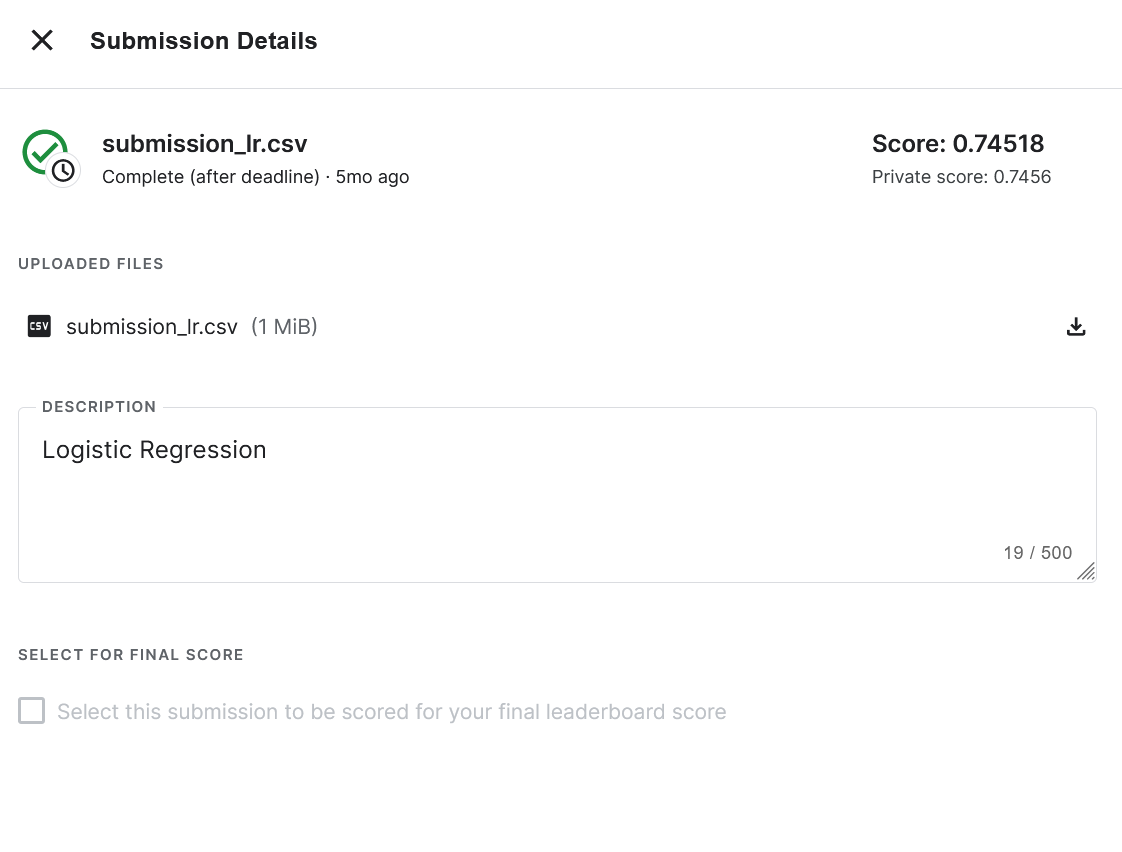)

__Conclusion Part 3__

Above we see how small changes to the machine learning algorithm and hyperparameters can have an impact on the ability to make a classification prediction about unkown data. The end result is that we are able to correctly predict default about 74 percent of the time which is certainly of value to achieve this business objective. Some additional improvements that can be made in future parts to this project include using different machine learning systems such as PyTorch or SparkML in order to test different approaches. Also we should work on balancing the dataset since we know that this dataset contains far more of the majority than the minority class. Additionally we could look at our column transformation process and pre-process the data in differnt ways, or we could look at creating a multiclass dataset to offer more granularity in prediction.